<a href="https://colab.research.google.com/github/ekity1002/kaggle-cassaba/blob/main/cassaba_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = ''
!gcloud config set project {project_id}

In [ ]:
!gsutil cp gs://casds/tfrecords_256x256.zip .


In [ ]:
#!unzip cassaba-5fold.zip
!unzip tfrecords_256x256.zip

In [18]:
! pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [19]:
import os
from functools import partial
import glob
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, ResNet50 
import tensorflow.keras.backend as K
import cv2
from PIL import Image
import albumentations as A

# TPU設定
* https://www.kaggle.com/docs/tpu
* dataset を publicにして上げる必要があるらしい

In [20]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# user_credential = user_secrets.get_gcloud_credential()
# user_secrets.set_tensorflow_credential(user_credential)

# # Step 2: Set the credentials
# user_secrets.set_tensorflow_credential(user_credential)

# # Step 3: Use a familiar call to get the GCS path of the dataset
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()    

In [21]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# TPU settings
* https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease

In [22]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
TRAIN_DIR='.'
INPUT_SHAPE=(512,512,3)
NUM_CLASSES=5
BATCH_SIZE=8 * strategy.num_replicas_in_sync
INITIAL_LR=0.01 #初期学習率
N_FOLD=5
SEED=888
CLASS_WEIGHT= {
    0: (1/0.050935) / 5.0,
    1: (1/0.102336) / 5.0,
    2: (1/0.111449) / 5.0,
    3: (1/0.614720) / 5.0,
    4: (1/0.120561) / 5.0,
}

def set_seed(seed=200):
    tf.random.set_seed(seed)
    np.random.seed(seed)# for numpy.random
    random.seed(seed) # for built-in random
    os.environ["PYTHONHASHSEED"] = str(seed)# for hash seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(SEED)

# baseline
* 水増し
* efficientnetB0 keras

In [24]:
def cutmix(image, label, proba=1.0):
    '''cutmix augmentation
    proba: cutmixを行う確率:0~1
    '''
    dim = INPUT_SHAPE[0] #height
    imgs=[]
    labels=[]
    print(image)
    print(label)
    
    for img1_idx in range(BATCH_SIZE):
        # cutmix を行うかどうか
        p = tf.cast(tf.random.uniform([], 0, 1) <= proba, tf.int32)
        
        # img1 とmixするimage
        img2_idx = tf.cast(tf.random.uniform([],0,BATCH_SIZE), tf.int32)
        
        x = tf.cast(tf.random.uniform([],0,dim), tf.int32)
        y = tf.cast(tf.random.uniform([],0,dim), tf.int32)
        b = tf.random.uniform([],0,1) #mix ratio
        
        #切り取り領域
        w = tf.cast(dim*tf.math.sqrt(1-b), tf.int32) * p
        ya = tf.math.maximum(0, y-w//2)
        yb = tf.math.maximum(dim, y+w//2)
        xa = tf.math.maximum(0, x-w//2)
        xb = tf.math.maximum(dim, x+w//2)
        
        # img1, img2の混合
        one = image[img1_idx, ya:yb, 0:xa,:]
        two = image[img2_idx, ya:yb, xa:xb,:]
        three = image[img1_idx, ya:yb, xb:dim,:]
        middle = tf.concat([one,two,three], axis=1) #width方向に連結
        img = tf.concat([image[img1_idx, 0:ya, :, :],
                         middle,
                         image[img2_idx, yb:dim, :, :]
                        ], axis=0) #height方向に連結
        imgs.append(img)

        # label mix
        a = tf.cast(w*w/dim/dim, tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[img1_idx], NUM_CLASSES)
            lab2 = tf.one_hot(label[img2_idx], NUM_CLASSES)
        else:
            lab1 = label[img1_idx,]
            lab2 = label[img2_idx,]
        labels.append((1-a)*lab1 + a*lab2)
        
    # reshape
#     print(labels)
#     print(tf.stack(labels))
    image2 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,dim,dim,3))
    label2 = tf.reshape(tf.stack(labels),(BATCH_SIZE,NUM_CLASSES))
    return image2, label2

In [25]:
#Albmentation
def train_aug_fn(image, img_size):
    trans_p=.85  # 変換の適用率
    height, width = img_size[0], img_size[1]
    # 適応
    # TODO:cutmix, augmixなど検討
    # https://nonbiri-tereka.hatenablog.com/entry/2020/01/06/082921
    trans_list = [
        A.HorizontalFlip(p=trans_p),
        A.Rotate(limit=90, p=trans_p),
        A.RandomContrast(p=trans_p),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),), #imagenet mean std
        #A.CLAHE(p=trans_p),
        #A.RGBShift(p=trans_p),
        A.RandomShadow(p=trans_p),
        #A.ISONoise(p=trans_p), #ISOノイズを加える
    ]
    if np.random.rand() > 0.5:
        trans_list += [
            A.CenterCrop(height=height, width=width, p=1),
            A.Cutout(max_h_size=20, max_w_size=20 ,p=trans_p),
        ]
    else:
        # crop
        trans_list += [
            A.CenterCrop(height=height, width=width, p=1),
            A.Cutout(max_h_size=20, max_w_size=20 ,p=trans_p),
        ]


    transforms = A.Compose(trans_list)        
    data = {'image':image}
    aug_data = transforms(**data)
    aug_img = aug_data['image']
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

def val_aug_fn(image, img_size):
    height, width = img_size[0], img_size[1]
    transforms = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),), #imagenet mean std
        #A.Resize(height=height, width=width, p=1)            
        A.CenterCrop(height=height, width=width,p=1),
    ])        
    data = {'image':image}
    aug_data = transforms(**data)
    aug_img = aug_data['image']
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

def test_aug_fn(image, img_size):
    height, width = img_size[0], img_size[1]
    # val or test
    transforms = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),), #imagenet mean std
        #A.Resize(height=height, width=width, p=1)            
        A.CenterCrop(height=height, width=width,p=1),
    ])        
    data = {'image':image}
    aug_data = transforms(**data)
    aug_img = aug_data['image']
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

def train_aug_process(image, label, img_size):
    aug_img = tf.numpy_function(func=train_aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

def val_aug_process(image, label, img_size):
    aug_img = tf.numpy_function(func=val_aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

def test_aug_process(image, label, img_size):
    aug_img = tf.numpy_function(func=test_aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [26]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.cast(image, tf.int32)
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = (
    {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_id': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'disease_name': tf.io.FixedLenFeature([], tf.string),
    }
    if labeled
    else {'image': tf.io.FixedLenFeature([], tf.string),
          'image_id': tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    
    if labeled:
        label = tf.cast(example['label'], tf.int32)
        label = tf.one_hot(label, NUM_CLASSES) #one_hot
        return image, label
    return image

def load_dataset(filenames, labeled=True, ignore_order=True):

    dataset = tf.data.TFRecordDataset(filenames) #listで渡せば複数ファイル読み込みも可能
    if ignore_order:
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False #データセットの順番を無視する設定。読み込みスピードアップ
        dataset = dataset.with_options(ignore_order)
        
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE) #(image, label) or image単体を返す    
    return dataset

def set_shapes(img, label, image_shape):
    img.set_shape(image_shape)
    label.set_shape(NUM_CLASSES)
    return img, label

def get_dataset(filenames, labeled=True, image_shape=(600, 800, 3), mode='train'):
    """
    filenames: 読み込みファイル名 list or string
    labeled: ラベル付きのデータセットを返すか否か
    image_shape: モデル入力に合わせる
    mode: 'train' or 'val' or 'test'
    """
    dataset = load_dataset(filenames, labeled=labeled)
    #print(dataset)
    if mode=='train':
        dataset = dataset.map(partial(train_aug_process, img_size=image_shape[:2]),
                              num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(partial(set_shapes, image_shape=image_shape),
                              num_parallel_calls=AUTOTUNE
                             )
        #print(dataset)
        dataset = dataset.repeat().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).map(cutmix)
        #dataset = dataset.repeat().batch(BATCH_SIZE).map(cutmix)
        #print(dataset)
        dataset = dataset.unbatch()
        dataset = dataset.batch(BATCH_SIZE)
    elif mode=='val':
        dataset = dataset.map(partial(val_aug_process, img_size=image_shape[:2]),
                              num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(partial(set_shapes, image_shape=image_shape),
                              num_parallel_calls=AUTOTUNE
                             )
        #print(dataset)
        dataset = dataset.batch(BATCH_SIZE)
    elif mode=='test':
        dataset = dataset.map(partial(test_aug_process, img_size=image_shape[:2]),
                              num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(partial(set_shapes, image_shape=image_shape),
                              num_parallel_calls=AUTOTUNE
                             )
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    #print(dataset)
    return dataset

def show_batch(dataset, row=5, col=5, figsize=(10, 10)):
    image_batch, label_batch = next(iter(dataset))
    plt.figure(figsize=figsize)
    for r in range(row):
        for c in range(col):
            ax = plt.subplot(row,col, r+c+1)
            #plt.imshow(image_batch[r+c])
            plt.imshow(image_batch[r+c].numpy().astype('uint8'))
            if label_batch is None:
                plt.title("TEST")
            else:
                plt.title(f'Label: {label_batch[r+c]}')
        plt.axis("off")

In [27]:
tra_path = f'{TRAIN_DIR}/train_fold{0}.tfrec'
val_path = f'{TRAIN_DIR}/val_fold{0}.tfrec'
tra_ds = get_dataset(tra_path, image_shape=INPUT_SHAPE, mode='train')
val_ds = get_dataset(val_path, image_shape=INPUT_SHAPE, mode='val')
print(tra_ds)
print(val_ds)

Tensor("args_0:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("args_1:0", shape=(None, 5), dtype=float32)
<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 5)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 5)), types: (tf.float32, tf.float32)>


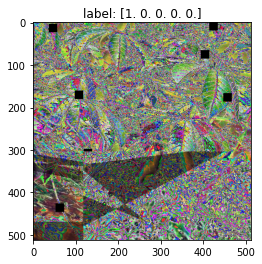

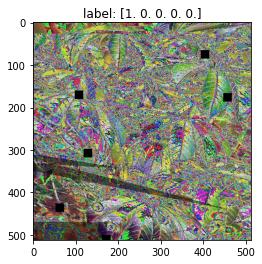

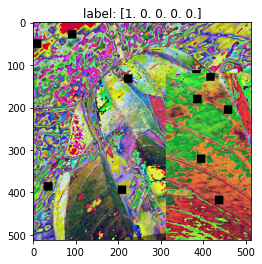

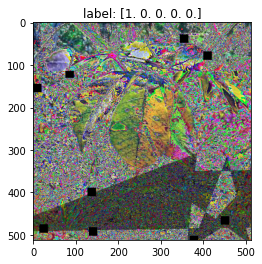

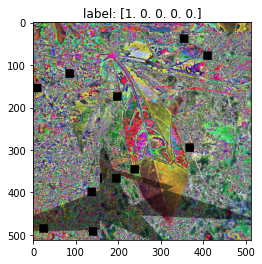

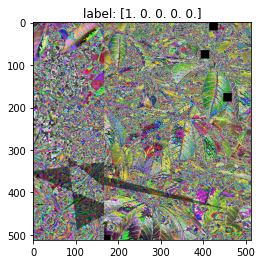

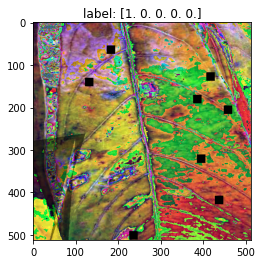

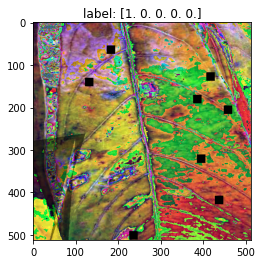

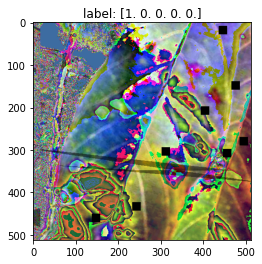

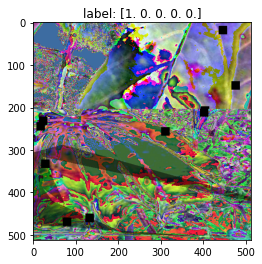

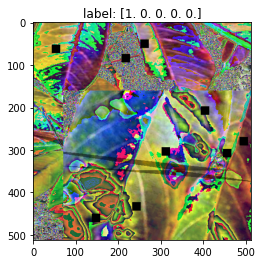

In [28]:
def iter_batch(dataset, n):
    i = 0
    for images, labels in iter(dataset):
        for image, label in zip(images, labels):
            plt.imshow(image)
            plt.title(f'label: {label}')
            plt.show()
            if i == n:
                break
            i+=1
        if i == n:
            break
            
iter_batch(tra_ds, 10)

In [29]:
#show_batch(tra_ds,row=2,col=3)
# show_batch(val_ds,row=2,col=3)

# KFold

In [30]:
def create_model(input_shape, num_classes, strategy):
    with strategy.scope():  
        inputs = Input(shape=input_shape)
        # base_model = EfficientNetB0(include_top=False, 
        #                             input_shape=None,
        #                             input_tensor=inputs)
        base_model = ResNet50(include_top=False, 
                              input_shape=None,
                              input_tensor=inputs)
        print(f'base layer num: {len(base_model.layers)}')
        for layer in base_model.layers[:145]:
            layer.trainable=False
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(num_classes, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=output)

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            INITIAL_LR, decay_steps=5, decay_rate=0.96, staircase=True
        )

        loss = tf.keras.losses.CategoricalCrossentropy( from_logits=False, label_smoothing=0.3, name='categorical_crossentropy' )
        model.compile(loss=loss,
                      #optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics='accuracy')
    return model


model = create_model(INPUT_SHAPE, NUM_CLASSES, strategy)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
base layer num: 175
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
_________

In [31]:
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    https://www.kaggle.com/dimasmunoz/keras-nn-with-cosine-annealing-lr
    # Usage
    ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self, min_lr, max_lr, steps_per_epoch, 
                     lr_decay=1, cycle_length=10, mult_factor=2):
         self.min_lr = min_lr
         self.max_lr = max_lr
         self.lr_decay = lr_decay

         self.batch_since_restart = 0
         self.next_restart = cycle_length

         self.steps_per_epoch = steps_per_epoch

         self.cycle_length = cycle_length
         self.mult_factor = mult_factor

         self.history = {}

    def clr(self):
        '''Calc learning rate'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5*(self.max_lr - self.min_lr) * (1 + np.cos( fraction_to_restart * np.pi ))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''record previsou batch statistics and update the learning rate'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''check for end of current cycle, apply restarts when necessary'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.restore_best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''set weights to the values from the end of the most recent cycle for best performance'''
        self.model.set_weights(self.restore_best_weights)



In [32]:

def callbacks(n_fold,  epoch_size):
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        f"cassaba_baseline_fold{n_fold}.h5", save_best_only=True
    )

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=7, monitor='val_loss', restore_best_weights=True
    )

    # lr_sched = SGDRScheduler(
    #     min_lr=1e-5, max_lr=1e-2, steps_per_epoch=np.ceil(epoch_size/BATCH_SIZE),
    #     lr_decay=0.85, mult_factor=1.5
    #     )
    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=5, verbose=0,
        mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
    )
    return [checkpoint_cb, early_stopping_cb, reduce_lr_cb]

def plot_acc_and_loss(history):
    """plot history"""
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']    
    epochs=range(1, len(acc)+1)    
    ax[0].plot(epochs, acc, label='Train')
    ax[0].plot(epochs, val_acc, label='Val')
    ax[0].legend()
    ax[0].set_title('Accuracy')
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs=range(1, len(loss)+1)
    ax[1].plot(epochs, loss, label='Train')
    ax[1].plot(epochs, val_loss, label='Val')
    ax[1].legend()
    ax[1].set_title('Loss')
    plt.show()

In [ ]:
EPOCHS=40

for i in range(N_FOLD):
    tra_path = f'{TRAIN_DIR}/train_fold{i}.tfrec'
    val_path = f'{TRAIN_DIR}/val_fold{i}.tfrec'
    num_records_tra = sum(1 for _ in tf.data.TFRecordDataset(tra_path))
    num_records_val = sum(1 for _ in tf.data.TFRecordDataset(val_path))
    print(f'tra_len:{num_records_tra}, val_len:{num_records_val}')
    tra_ds = get_dataset(tra_path, image_shape=INPUT_SHAPE, mode='train')
    val_ds = get_dataset(val_path, image_shape=INPUT_SHAPE, mode='val')
    steps_per_epoch_tra = (num_records_tra-1) // BATCH_SIZE + 1
    steps_per_epoch_val  = (num_records_val-1) // BATCH_SIZE + 1
    print(f'step_tra_len:{steps_per_epoch_tra}, step_val_len:{steps_per_epoch_val}')
    
    model = create_model(INPUT_SHAPE, NUM_CLASSES, strategy)
    cb = callbacks(n_fold=i, epoch_size=steps_per_epoch_tra)
    history = model.fit(tra_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=steps_per_epoch_tra,
                        validation_data=val_ds, validation_steps=steps_per_epoch_val,
                        callbacks=cb, shuffle=True,
                        #class_weight=CLASS_WEIGHT
                        )
    plot_acc_and_loss(history)
    print(f'Train FOLD{i} finish.')
    break

tra_len:17117, val_len:4280
Tensor("args_0:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("args_1:0", shape=(None, 5), dtype=float32)
step_tra_len:2140, step_val_len:535
base layer num: 175
Epoch 1/40
2140/2140 [==============================] - 574s 257ms/step - loss: 1.0612 - accuracy: 0.8662 - val_loss: 2.3751 - val_accuracy: 0.0509
Epoch 2/40
2140/2140 [==============================] - 543s 254ms/step - loss: 1.0965 - accuracy: 0.8328 - val_loss: 2.4355 - val_accuracy: 0.0509
Epoch 3/40
2140/2140 [==============================] - 546s 255ms/step - loss: 1.0798 - accuracy: 0.8405 - val_loss: 2.1869 - val_accuracy: 0.0509
Epoch 4/40
2140/2140 [==============================] - 545s 255ms/step - loss: 1.0876 - accuracy: 0.8285 - val_loss: 2.5662 - val_accuracy: 0.0509
Epoch 5/40
2140/2140 [==============================] - 543s 254ms/step - loss: 1.0908 - accuracy: 0.8267 - val_loss: 2.6925 - val_accuracy: 0.0509
Epoch 6/40
2140/2140 [==============================] - 539s 252

KeyboardInterrupt: ignored